In [1]:
%load_ext autoreload
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%autoreload

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from keras.optimizers import RMSprop
from keras import backend as K
from keras.models import load_model
%matplotlib inline

import pickle

#
from vgg16_siamese import vgg16_siamese, contrastive_loss
import data_processing as data_p

IMG_DIR = "../../data/ssd-images/"

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# load training data
train_batches = pickle.load(open('./batches/train_batches.pkl', 'rb'))
# val_batches = pickle.load(open('./batches/fake_split_train_batches.pkl', 'rb'))
test_batches = pickle.load(open('./batches/test_batches.pkl', 'rb'))

In [4]:
input_shape = (64, 64, 3) # 64x64 rgb images
siamese_network = vgg16_siamese(input_shape)

siamese_network.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 512)          16026432    input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_1[1][0]                    
          

In [5]:
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

def to_img_pairs(batch):
    return data_p.df_to_img_pair(batch, IMG_DIR)

train_img_batches = map(to_img_pairs, train_batches)
# val_img_batches = map(to_img_pairs, val_batches)
test_img_batches = map(to_img_pairs, test_batches)

rms = RMSprop()
siamese_network.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
train_history = siamese_network.fit_generator(
    train_img_batches,
    steps_per_epoch=50,
    epochs=40,
    validation_data=train_img_batches,
    validation_steps=15,
)

Epoch 1/40
50/50 [==============================] - 84s 2s/step - loss: 0.4654 - accuracy: 0.6198 - val_loss: 0.2337 - val_accuracy: 0.6375
Epoch 2/40
50/50 [==============================] - 76s 2s/step - loss: 0.2040 - accuracy: 0.6973 - val_loss: 0.2062 - val_accuracy: 0.7069
Epoch 3/40
50/50 [==============================] - 76s 2s/step - loss: 0.1984 - accuracy: 0.7135 - val_loss: 0.1969 - val_accuracy: 0.7042
Epoch 4/40
50/50 [==============================] - 76s 2s/step - loss: 0.2006 - accuracy: 0.7021 - val_loss: 0.1983 - val_accuracy: 0.7028
Epoch 5/40
50/50 [==============================] - 76s 2s/step - loss: 0.1829 - accuracy: 0.7427 - val_loss: 0.1768 - val_accuracy: 0.7625
Epoch 6/40
50/50 [==============================] - 76s 2s/step - loss: 0.1883 - accuracy: 0.7235 - val_loss: 0.1866 - val_accuracy: 0.7500
Epoch 7/40
50/50 [==============================] - 76s 2s/step - loss: 0.1869 - accuracy: 0.7163 - val_loss: 0.1852 - val_accuracy: 0.7417
Epoch 8/40
50/50 [==

/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


50/50 [==============================] - 76s 2s/step - loss: 0.1706 - accuracy: 0.7587 - val_loss: 0.1666 - val_accuracy: 0.7861
Epoch 17/40
50/50 [==============================] - 76s 2s/step - loss: 0.1687 - accuracy: 0.7588 - val_loss: 0.1671 - val_accuracy: 0.7826
Epoch 18/40
50/50 [==============================] - 76s 2s/step - loss: 0.1705 - accuracy: 0.7667 - val_loss: 0.1659 - val_accuracy: 0.7576
Epoch 19/40
50/50 [==============================] - 76s 2s/step - loss: 0.1607 - accuracy: 0.7710 - val_loss: 0.1670 - val_accuracy: 0.7590
Epoch 20/40
50/50 [==============================] - 76s 2s/step - loss: 0.1637 - accuracy: 0.7729 - val_loss: 0.1713 - val_accuracy: 0.7507
Epoch 21/40
50/50 [==============================] - 76s 2s/step - loss: 0.1644 - accuracy: 0.7675 - val_loss: 0.1647 - val_accuracy: 0.7792
Epoch 22/40
50/50 [==============================] - 76s 2s/step - loss: 0.1605 - accuracy: 0.7796 - val_loss: 0.1504 - val_accuracy: 0.8111
Epoch 23/40
50/50 [======

In [6]:
siamese_network.save('./svgg16_model_5_5.h5')

In [7]:
# compute final accuracy on training and test sets
tr_img_batches = map(to_img_pairs, train_batches)
te_img_batches = map(to_img_pairs, test_batches)

# tr_loss, tr_acc = siamese_network.evaluate_generator(tr_img_batches, steps=50)
te_loss, te_acc = siamese_network.evaluate_generator(te_img_batches, steps=1000)

# print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on test set: 80.64%


In [8]:
# siamese_network.save('./svgg16_model_small_0.h5')


test_batches[1]

,id_0,id_1,match
40066,7084db41e7781b1ba3762179700e7a04bc307f0b,5b9361958cbe0888aaa0cb6c6452c41247904716,False
56133,44dfa81a1f699e80ce3a682db25e82a774152116,4a6aafd0c8d6f7de71b697b09c1c5f6573eea797,True
18831,55fdbc21ef9089f1721e2f3be7b4dfb22216d002,ceac2bcccb02d7944b933fed02d0e6805a83c0e7,False
68610,261eb65bd320020097360a875f79b7f08980ff1d,659fd01bf228e18b672d59de57c28e394de9c2e7,False
29410,39573bb29e50777f08b3291397efbc0053d675de,9cbda1dced2ad49155b98b0e86a158d350dfdfc2,False
13707,5bfa8ea84bed2c3b5fc0537a01b2d9cefbaf78d1,e84700b5497cf4acec9c6762b9e531bbaad3ec7f,False
21553,a8b5bafeee96ed652fe46c60acda8d51dd5e5b5a,3725834b8cb040087f40dbd176a0e8a0a7f5a62c,False
77674,ed41306930dcf2402d7121dfb3cefdf23db494b1,b373ef9a84ddae9dcc0647f022828cb7e47f7747,False
9536,20b3a374a6fe6784f16325f4f8163b7d662d95e1,bd39dd29c349221d2693da154a942f477fd682e2,True
70435,1364eb28726a63adb311ac59b77c063124c777f1,c08279c9e24928ad8ec996f2e8d79bfe1eae3557,False


In [9]:
test_img_a, test_img_b = data_p.preprocess_input(np.array([
    data_p.id_to_jpg('5bfa8ea84bed2c3b5fc0537a01b2d9cefbaf78d1', IMG_DIR),
    data_p.id_to_jpg('e84700b5497cf4acec9c6762b9e531bbaad3ec7f', IMG_DIR)
]), mode='tf')
siamese_network.predict_on_batch([np.array([test_img_a]), np.array([test_img_b])])

array([[0.44686267]], dtype=float32)

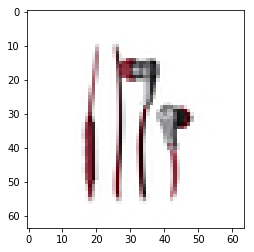

In [10]:
plt.imshow(data_p.id_to_jpg('5bfa8ea84bed2c3b5fc0537a01b2d9cefbaf78d1', IMG_DIR) / 255)

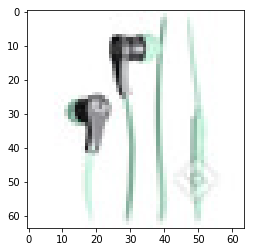

In [11]:
plt.imshow(np.flip(data_p.id_to_jpg('e84700b5497cf4acec9c6762b9e531bbaad3ec7f', IMG_DIR) / 255, axis=1))

In [14]:
tr_img_batches = map(to_img_pairs, train_batches)
tr_loss, tr_acc = siamese_network.evaluate_generator(tr_img_batches, steps=1000)

/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [15]:
tr_acc

0.8097708333730698